In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [5]:
%matplotlib inline

wmf.mpl.style()

In [6]:
m = pd.read_csv(
    "../metrics/metrics.tsv", 
    sep="\t",
    parse_dates=["month"]
).set_index("month")

# Monthly active editors

In [7]:
m["existing_active_editors"] = m["active_editors"] - m["new_active_editors"] - m["second_month_active_editors"]
m = m.drop("active_editors", axis = 1)
eds = m[["existing_active_editors", "second_month_active_editors", "new_active_editors"]]

In [8]:
eds.columns = ['existing active editors', 'second month active editors',
       'new (first-month) active editors']
eds.tail()

,existing active editors,second month active editors,new (first-month) active editors
month,,,
2018-03-01,64218.0,4347.0,17625.0
2018-04-01,62907.0,4739.0,16059.0
2018-05-01,63569.0,4068.0,17787.0
2018-06-01,59880.0,3664.0,15005.0
2018-07-01,60242.0,3455.0,14037.0


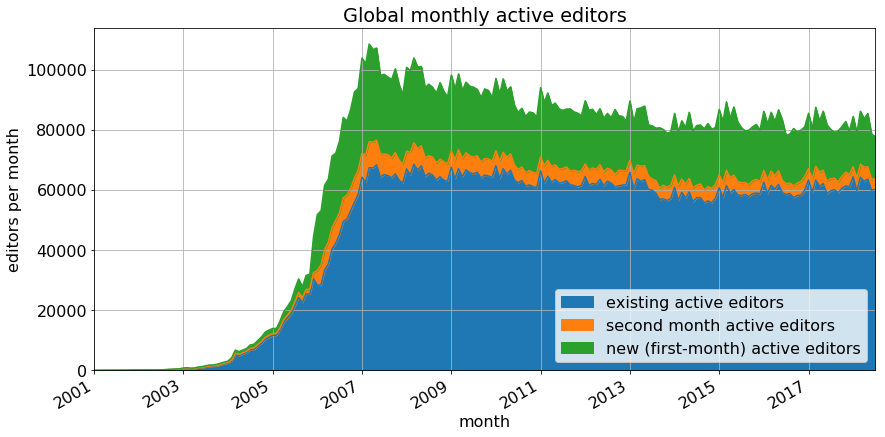

In [9]:
ax = eds.plot.area()
plt.title("Global monthly active editors")
plt.ylabel("editors per month")
plt.autoscale(enable=True, axis="x", tight=True);

# Active Wikipedia editors

In [ ]:
act_wp = wmf.mariadb.run("""
select 
    month,
    wiki,
    count(*) as active_editors,
    sum(extract(year_month from reg) = extract(year_month from month)) as new_active_editors,
    sum(extract(year_month from reg) = extract(year_month from date_sub(month, interval 1 month))) as second_month_active_editors
from (
    select
        month,
        if(wiki = "enwiki", "enwiki", "other") as wiki,
        -- Convert from BINARY to CHAR so that case-insentive regexes work
        convert(user_name using utf8) as name,
        sum(content_edits) as content_edits,
        max(bot_flag) as bot_flag,
        min(user_registration) as reg
    from staging.editor_month
    inner join enwiki.sites
    on wiki = site_global_key
    where
        site_group = "wikipedia" and
        month >= "{start}" and
        local_user_id != 0
    group by 
        month,
        (wiki = "enwiki"),
        name
) global_edits
where
    content_edits >= 5 and
    -- A user is a bot if they have a matching name or have the bot flag on *any* wiki
    -- See https://meta.wikimedia.org/wiki/Research:Active_editor and https://meta.wikimedia.org/wiki/Research:Bot_user
    bot_flag = 0 and (
        name not regexp "bot\\\\b" or
        name in ("Paucabot", "Niabot", "Marbot")    
    )
group by 
    month,
    wiki
""".format(start="2001-01-01"))

In [19]:
act_wp = act_wp.pivot(index="month", columns="wiki")

In [56]:
eae = act_wp["active_editors"] - act_wp["new_active_editors"] - act_wp["second_month_active_editors"]
eae.columns = pd.MultiIndex.from_product([["existing_active_editors"], ["enwiki", "other"]])

In [59]:
act_wp = act_wp.join(eae)

In [75]:
r_act_wp = act_wp.ewm(alpha=0.7).mean().rename({"enwiki": "English Wikipedia", "other": "Other Wikipedias"}, axis=1)

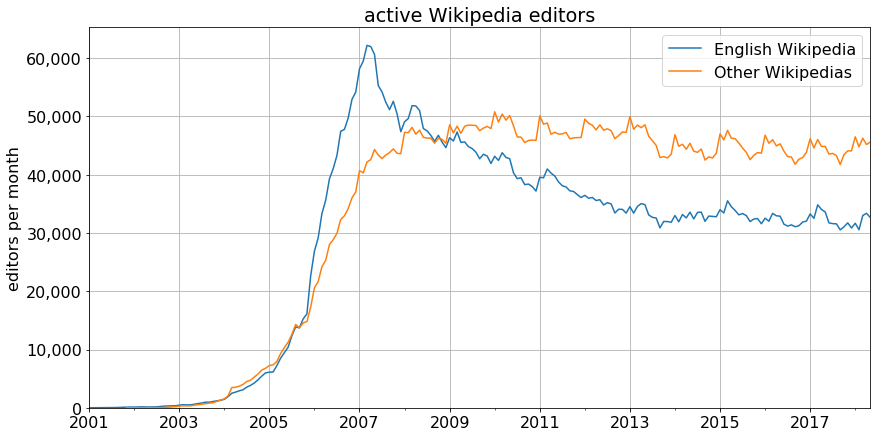

In [79]:
ax = r_act_wp["active_editors"].plot(ylim=0, title="active Wikipedia editors")
plt.ylabel("editors per month")
plt.xlabel("")
ax.legend().set_title("")
ax.yaxis.set_major_formatter(comma_fmt)
plt.autoscale(enable=True, axis="x", tight=True);

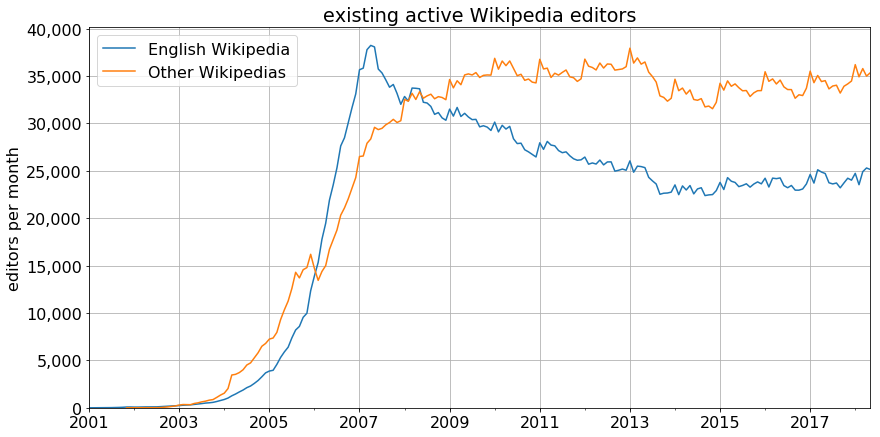

In [80]:
ax = r_act_wp["existing_active_editors"].plot(ylim=0, title="existing active Wikipedia editors")
plt.ylabel("editors per month")
plt.xlabel("")
ax.legend().set_title("")
ax.yaxis.set_major_formatter(comma_fmt)
plt.autoscale(enable=True, axis="x", tight=True);

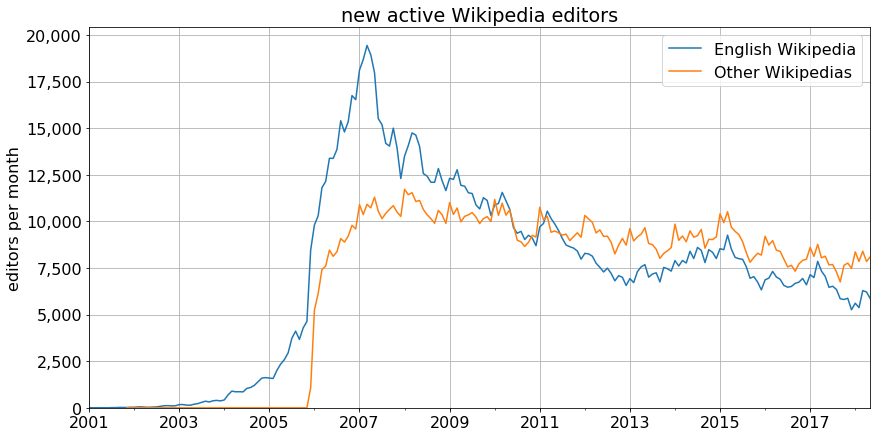

In [81]:
ax = r_act_wp["new_active_editors"].plot(ylim=0, title="new active Wikipedia editors")
plt.ylabel("editors per month")
plt.xlabel("")
ax.legend().set_title("")
ax.yaxis.set_major_formatter(comma_fmt)
plt.autoscale(enable=True, axis="x", tight=True);

## Very active editors

In [ ]:
vae = wmf.mariadb.run("""
    select 
        month, 
        count(*) as very_active_editors
    from (
        select
            month,
            -- Convert from BINARY to CHAR so that case-insentive regexes work
            convert(user_name using utf8) as name,
            sum(content_edits) as content_edits,
            max(bot_flag) as bot_flag,
            min(user_registration) as reg
        from staging.editor_month
        where 
            month >= "{start}" and
            local_user_id != 0
        group by month, name
    ) global_edits
    where
        content_edits >= 100 and
        -- A user is a bot if they have a matching name or have the bot flag on *any* wiki
        -- See https://meta.wikimedia.org/wiki/Research:Active_editor and https://meta.wikimedia.org/wiki/Research:Bot_user
        bot_flag = 0 and (
            name not regexp "bot\\\\b" or
            name in ("Paucabot", "Niabot", "Marbot")    
        )
    group by month;
""".format(start="2014-06-01"))

In [12]:
vae["month"] = vae["month"].apply(pd.to_datetime)
vae = vae.set_index("month")

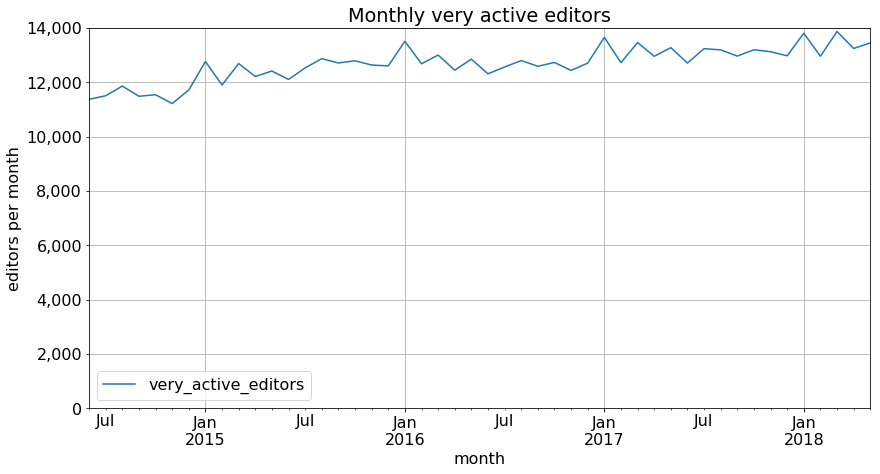

In [49]:
vae.plot()
ax = plt.gca()
plt.title("Monthly very active editors")
ax.yaxis.set_major_formatter(comma_fmt)
plt.ylabel("editors per month")
plt.ylim(ymin=0)
plt.autoscale(enable=True, axis="x", tight=True)
plt.savefig('vae.png', bbox_inches='tight');

## Very active editors by project

In [8]:
pvae_raw = wmf.mariadb.run("""
    select 
        month,
        wiki,
        count(*) as very_active_editors
    from staging.editor_month
    where
        content_edits >= 100 and
        local_user_id != 0 and
        month >= "{start}" and
        -- A user is a bot if they have a matching name or have the bot flag on *any* wiki
        -- See https://meta.wikimedia.org/wiki/Research:Active_editor and https://meta.wikimedia.org/wiki/Research:Bot_user
        bot_flag = 0 and (
            convert(user_name using utf8) not regexp "bot\\\\b" or
            convert(user_name using utf8) in ("Paucabot", "Niabot", "Marbot")    
        )
    group by wiki, month;
""".format(start="2014-06-01"))

In [9]:
pvae = pvae_raw.pivot(index="month", columns="wiki").fillna(0)
pvae.columns = pvae.columns.droplevel(0)
pvae.index = pd.to_datetime(pvae.index)
pvae.tail()

wiki,abwiki,acewiki,adywiki,afwiki,afwiktionary,akwiki,alswiki,amwiki,amwiktionary,angwiki,...,zh_min_nanwiktionary,zh_yuewiki,zhwiki,zhwikibooks,zhwikinews,zhwikiquote,zhwikisource,zhwikivoyage,zhwiktionary,zuwiki
month,,,,,,,,,,,,,,,,,,,,,
2018-02-01,1.0,1.0,0.0,14.0,2.0,0.0,3.0,1.0,0.0,0.0,...,0.0,9.0,344.0,1.0,0.0,0.0,8.0,2.0,4.0,1.0
2018-03-01,0.0,0.0,0.0,9.0,2.0,1.0,3.0,1.0,0.0,1.0,...,1.0,14.0,370.0,1.0,0.0,2.0,6.0,2.0,3.0,1.0
2018-04-01,0.0,0.0,0.0,6.0,0.0,1.0,2.0,1.0,0.0,1.0,...,0.0,7.0,401.0,1.0,0.0,0.0,9.0,2.0,2.0,1.0
2018-05-01,1.0,0.0,0.0,9.0,0.0,0.0,3.0,1.0,0.0,1.0,...,0.0,10.0,371.0,2.0,1.0,1.0,7.0,2.0,2.0,0.0
2018-06-01,0.0,1.0,0.0,9.0,0.0,0.0,4.0,1.0,0.0,0.0,...,0.0,5.0,390.0,1.0,0.0,0.0,6.0,3.0,2.0,0.0


In [12]:
def segment(wiki):
    if wiki == "enwiki":
        return "English Wikipedia"
    elif wiki == "commonswiki":
        return "Commons"
    elif wiki == "wikidatawiki":
        return "Wikidata"
    else:
        return "Other projects"

pvae_seg = pvae.groupby(segment, axis = 1).sum()

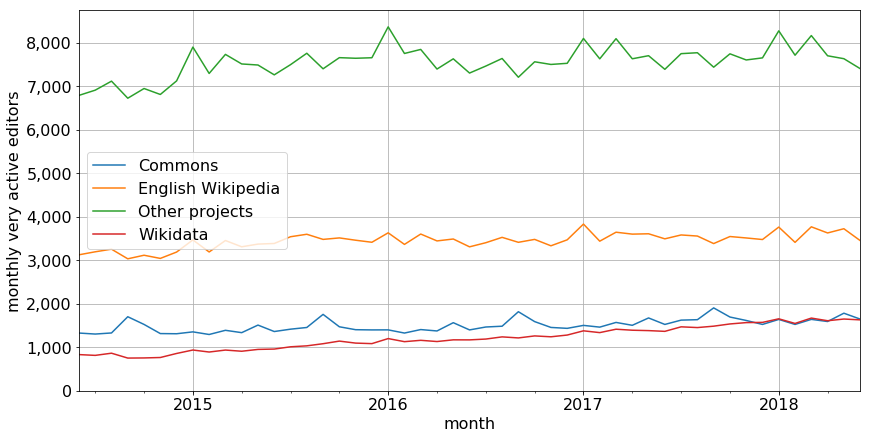

In [14]:
pvae_seg.plot(ylim=0)
ax = plt.gca()
ax.yaxis.set_major_formatter(comma_fmt)
plt.ylabel("monthly very active editors")
plt.autoscale(enable=True, axis="x", tight=True);